In [10]:
%pip install python-chess pandas

Note: you may need to restart the kernel to use updated packages.


`plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 用于显示中文，Mac用户可用 'Arial Unicode MS'`

In [ ]:
import chess.pgn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 设置绘图风格
sns.set(style="darkgrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文显示
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 用于显示中文，Mac用户可用 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings('ignore')

# 配置
pgn_filename = "lichess_db_standard_rated_2025-11.pgn" # 确保文件名正确
GAMES_TO_PROCESS = 2000 # 建议跑 10000 局以上以获得清晰的热力图

print("环境配置完成！准备开始挖掘...")

环境配置完成！准备开始挖掘...


In [12]:
# --- 全局变量：全棋子死亡热力图字典 (新增了 KING) ---
piece_death_heatmaps = {
    chess.PAWN: np.zeros((8, 8)),
    chess.KNIGHT: np.zeros((8, 8)),
    chess.BISHOP: np.zeros((8, 8)),
    chess.ROOK: np.zeros((8, 8)),
    chess.QUEEN: np.zeros((8, 8)),
    chess.KING: np.zeros((8, 8)) # 新增：王的葬身之地
}

# --- 辅助函数 ---
def is_knight_on_edge(move):
    to_sq = move.to_square
    col = chess.square_file(to_sq)
    row = chess.square_rank(to_sq)
    return col == 0 or col == 7 or row == 0 or row == 7

# --- 数据提取主循环 ---
data = []
count = 0
# 如果之前的 cell 没运行，这里重新定义一下
if 'GAMES_TO_PROCESS' not in globals():
    GAMES_TO_PROCESS = 10000

print(f"正在处理前 {GAMES_TO_PROCESS} 局游戏，包含'王被将杀'统计...")

with open(pgn_filename) as pgn_file:
    while count < GAMES_TO_PROCESS:
        try:
            game = chess.pgn.read_game(pgn_file)
        except:
            break
        if game is None: break
        
        headers = game.headers
        if "?" in headers.get("WhiteElo", "?") or "?" in headers.get("BlackElo", "?"):
            continue

        board = game.board()
        
        # 特征变量初始化
        white_castling_ply = 0
        white_knight_edge_count = 0
        white_queen_moves = 0
        mobility_counts = []
        opening_moves = []
        ply_count = 0
        
        # 遍历每一层棋
        for move in game.mainline_moves():
            ply_count += 1
            
            # --- 1. 统计常规吃子 (兵、马、象、车、后) ---
            if board.is_capture(move):
                dest = move.to_square
                row, col = 7 - chess.square_rank(dest), chess.square_file(dest)
                
                if board.is_en_passant(move):
                    piece_death_heatmaps[chess.PAWN][row][col] += 1
                else:
                    victim = board.piece_at(dest)
                    if victim:
                        ptype = victim.piece_type
                        if ptype in piece_death_heatmaps and ptype != chess.KING:
                            piece_death_heatmaps[ptype][row][col] += 1

            # --- 2. 提取其他特征 ---
            if ply_count <= 6:
                opening_moves.append(board.san(move))
            
            if board.turn == chess.WHITE:
                mobility_counts.append(board.legal_moves.count())
                
                piece = board.piece_at(move.from_square)
                if piece and piece.piece_type == chess.QUEEN:
                    white_queen_moves += 1
                if board.is_castling(move) and white_castling_ply == 0:
                    white_castling_ply = (ply_count + 1) // 2
                if piece and piece.piece_type == chess.KNIGHT and is_knight_on_edge(move):
                    white_knight_edge_count += 1
            
            board.push(move)
        
        # --- 3. [新功能] 游戏结束：检查是否是将杀 (Checkmate) ---
        if board.is_checkmate():
            # 被将杀的一方是当前轮到走棋的一方 (board.turn)
            loser_color = board.turn 
            king_square = board.king(loser_color)
            
            if king_square is not None:
                row, col = 7 - chess.square_rank(king_square), chess.square_file(king_square)
                piece_death_heatmaps[chess.KING][row][col] += 1

        if ply_count < 10: continue

        row = [
            int(headers.get("WhiteElo")),
            " ".join(opening_moves),
            np.mean(mobility_counts) if mobility_counts else 0,
            white_castling_ply if white_castling_ply > 0 else 50,
            white_knight_edge_count,
            white_queen_moves,
            ply_count
        ]
        data.append(row)
        
        count += 1
        if count % 20000 == 0: print(f"已处理 {count} 局...")

# 生成 DataFrame
df = pd.DataFrame(data, columns=["Elo", "Opening", "AvgMobility", "CastlingPly", "EdgeKnight", "QueenMoves", "TotalPly"])
def classify_elo(elo):
    if elo < 1500: return "Beginner"
    if elo < 1900: return "Intermediate"
    return "Expert"
df['Level'] = df['Elo'].apply(classify_elo)

print("全棋子（含王被将杀）数据提取完毕！")

正在处理前 600000 局游戏，包含'王被将杀'统计...
已处理 20000 局...
已处理 40000 局...
已处理 60000 局...
已处理 80000 局...
已处理 100000 局...
已处理 120000 局...
已处理 140000 局...
已处理 160000 局...
已处理 180000 局...
已处理 200000 局...
已处理 220000 局...
已处理 240000 局...
已处理 260000 局...
已处理 280000 局...
已处理 300000 局...
已处理 320000 局...
已处理 340000 局...
已处理 360000 局...
已处理 380000 局...
已处理 400000 局...
已处理 420000 局...
已处理 440000 局...
已处理 460000 局...
已处理 480000 局...
已处理 500000 局...
已处理 520000 局...
已处理 540000 局...
已处理 560000 局...
已处理 580000 局...
已处理 600000 局...
全棋子（含王被将杀）数据提取完毕！


当前数据量: 600000，筛选热门开局阈值: > 3000 次
【提示】图已构建，但没有节点匹配到 ELO 数据。可能是节点命名不匹配。


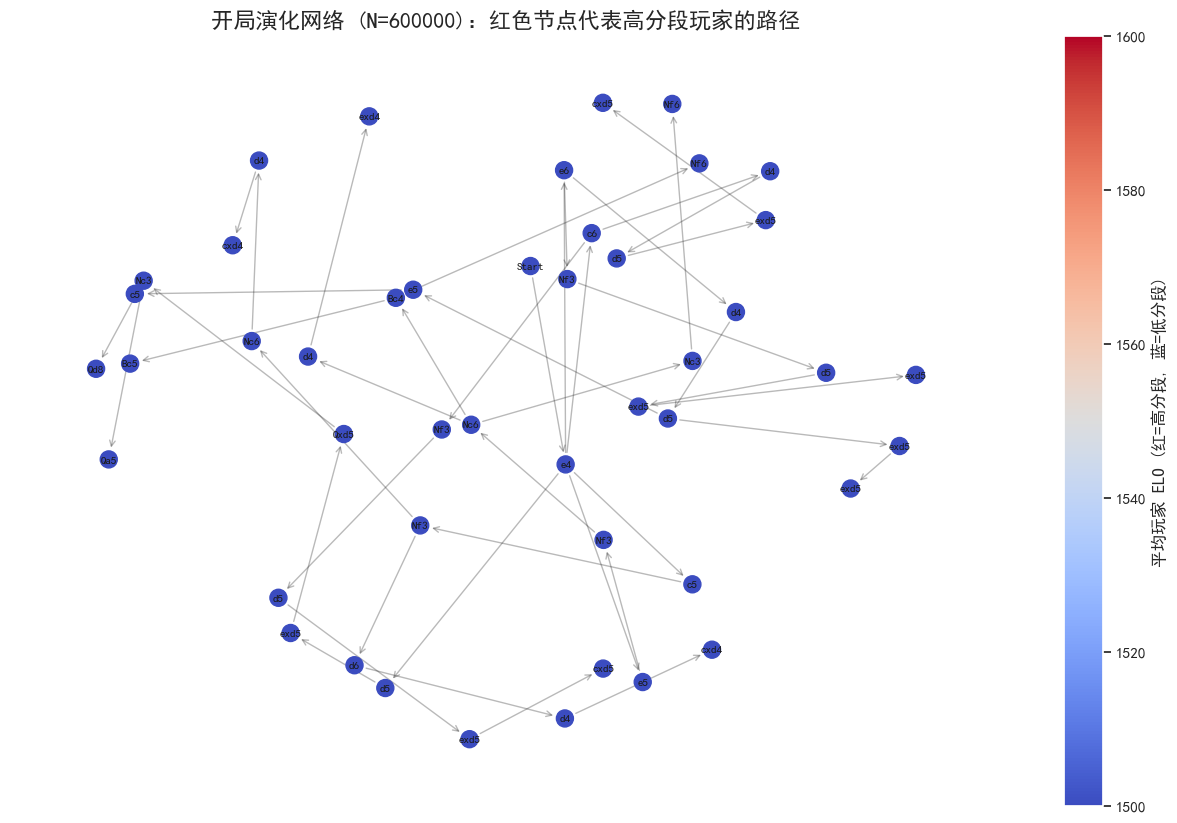

In [13]:
# Cell 3: [修复版] 话题一：开局演化网络

# 1. 准备数据
if 'Opening' not in df.columns:
    # 兼容旧版列名
    if 'OpeningSequence' in df.columns:
        df['Opening'] = df['OpeningSequence']
    else:
        print("【错误】数据中找不到开局列，请重新运行 Cell 2")

# 统计开局数据
opening_stats = df.groupby('Opening').agg({
    'Elo': 'mean',
    'TotalPly': 'count'
}).rename(columns={'TotalPly': 'Count', 'Elo': 'AvgElo'})

# --- 【关键修复】动态调整阈值 ---
# 如果总局数很少（比如调试时只跑了1000局），阈值设为 1 次即可
# 如果局数多，设为 0.5%
data_len = len(df)
if data_len < 2000:
    threshold = 1  # 数据少时，只要出现过就画
else:
    threshold = int(data_len * 0.005) # 数据多时，取前0.5%

print(f"当前数据量: {data_len}，筛选热门开局阈值: > {threshold} 次")

top_openings = opening_stats[opening_stats['Count'] > threshold]

if top_openings.empty:
    print("【提示】没有满足阈值的开局。原因可能是数据量太少，或者开局太分散。")
    print("尝试将 Cell 1 中的 GAMES_TO_PROCESS 调大 (建议 > 5000) 并重跑。")
else:
    # 2. 构建图
    G = nx.DiGraph()
    for seq in top_openings.index:
        moves = str(seq).split(" ")
        path = "Start"
        for move in moves:
            next_node = path + " " + move
            if not G.has_edge(path, next_node):
                G.add_edge(path, next_node)
            path = next_node

    # 3. 准备颜色数据
    node_elos = []
    for node in G.nodes():
        if node in opening_stats.index:
            node_elos.append(opening_stats.loc[node]['AvgElo'])
    
    # --- 【关键修复】防止空列表报错 ---
    if len(node_elos) == 0:
        print("【提示】图已构建，但没有节点匹配到 ELO 数据。可能是节点命名不匹配。")
        # 给一个默认范围防止报错
        vmin, vmax = 1500, 1600
        colors = [1500] * len(G.nodes())
    else:
        # 动态计算颜色范围 (5% - 95%) 防止极端值干扰
        vmin = np.percentile(node_elos, 5)
        vmax = np.percentile(node_elos, 95)
        print(f"颜色映射范围 (ELO): {vmin:.1f} - {vmax:.1f}")

        colors = []
        for node in G.nodes():
            if node == "Start":
                colors.append((vmin + vmax) / 2)
            elif node in opening_stats.index:
                colors.append(opening_stats.loc[node]['AvgElo'])
            else:
                colors.append(vmin)

    # 4. 绘图
    plt.figure(figsize=(16, 10))
    pos = nx.spring_layout(G, k=0.6, iterations=50)
    ax = plt.gca()

    nx.draw_networkx_nodes(G, pos, node_size=150, node_color=colors, 
                           cmap='coolwarm', vmin=vmin, vmax=vmax, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.3, arrowstyle='->', ax=ax)
    
    # 优化标签显示：只显示最后一步
    labels = {n: n.split(" ")[-1] for n in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)

    # Colorbar
    sm = cm.ScalarMappable(cmap='coolwarm', norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="平均玩家 ELO (红=高分段, 蓝=低分段)")
    
    plt.title(f"开局演化网络 (N={data_len})：红色节点代表高分段玩家的路径", fontsize=16)
    plt.axis('off')
    plt.show()

In [14]:
# # 1. 准备数据
# opening_stats = df.groupby('Opening').agg({
#     'Elo': 'mean',
#     'TotalPly': 'count'
# }).rename(columns={'TotalPly': 'Count', 'Elo': 'AvgElo'})

# # 筛选热门开局
# threshold = max(5, int(len(df) * 0.005))
# top_openings = opening_stats[opening_stats['Count'] > threshold]

# # 2. 构建图
# G = nx.DiGraph()
# for seq in top_openings.index:
#     moves = str(seq).split(" ")
#     path = "Start"
#     for move in moves:
#         next_node = path + " " + move
#         if not G.has_edge(path, next_node):
#             G.add_edge(path, next_node)
#         path = next_node

# # 3. 智能颜色映射 (解决全红问题)
# node_elos = []
# valid_nodes = []
# for node in G.nodes():
#     if node in opening_stats.index:
#         elo = opening_stats.loc[node]['AvgElo']
#         node_elos.append(elo)
#         valid_nodes.append(node)

# # 计算真正的颜色范围（排除极端值，取 5% - 95% 区间）
# vmin = np.percentile(node_elos, 5)
# vmax = np.percentile(node_elos, 95)
# print(f"颜色映射范围 (ELO): {vmin:.1f} - {vmax:.1f}")

# # 为每个节点赋值颜色
# colors = []
# for node in G.nodes():
#     if node == "Start":
#         colors.append((vmin + vmax) / 2) # 起点设为中性色
#     elif node in opening_stats.index:
#         colors.append(opening_stats.loc[node]['AvgElo'])
#     else:
#         colors.append(vmin) # 未知节点设为冷色

# # 4. 绘图
# plt.figure(figsize=(16, 10))
# pos = nx.spring_layout(G, k=0.6, iterations=50)
# ax = plt.gca()

# # 绘图
# nodes = nx.draw_networkx_nodes(G, pos, node_size=150, node_color=colors, 
#                                cmap='coolwarm', vmin=vmin, vmax=vmax, ax=ax)
# nx.draw_networkx_edges(G, pos, alpha=0.3, arrowstyle='->', ax=ax)
# nx.draw_networkx_labels(G, pos, labels={n: n.split(" ")[-1] for n in G.nodes()}, 
#                         font_size=8, ax=ax)

# # 添加 Colorbar
# sm = cm.ScalarMappable(cmap='coolwarm', norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# plt.colorbar(sm, ax=ax, label="平均玩家 ELO (红=高分段, 蓝=低分段)")
# plt.title("开局演化网络：高分段玩家的开局选择路径", fontsize=16)
# plt.axis('off')
# plt.show()

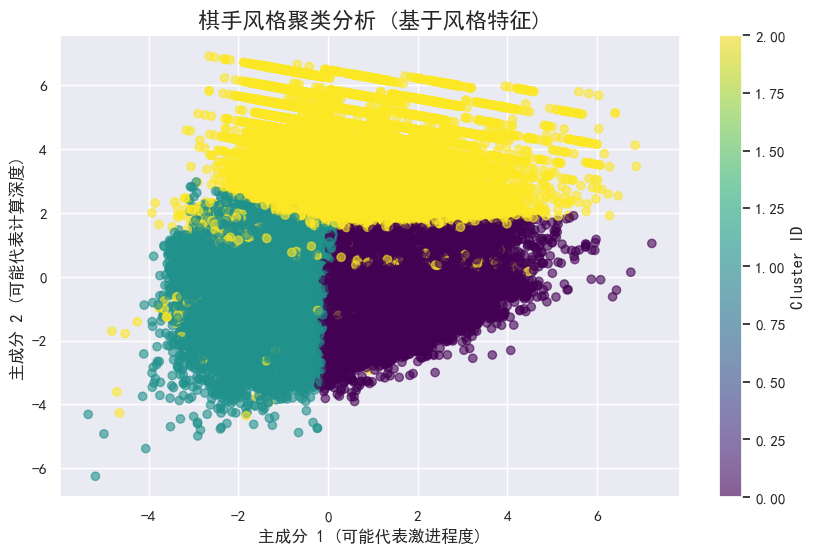

=== 聚类结果解读 ===
                 Elo  QueenMoves  CastlingPly  AvgMobility
Cluster                                                   
0        1686.753183    5.928284    14.035984    35.388153
1        1662.692300    2.840515    17.155361    27.716706
2        1443.925696    1.531725    50.000000    32.136594


In [15]:
# 1. 构造特征向量
# 归一化特征：比如动后次数要除以总步数，否则长对局动后次数天然多
cluster_data = pd.DataFrame()
cluster_data['Queen_Ratio'] = df['QueenMoves'] / df['TotalPly']
cluster_data['Edge_Knight_Ratio'] = df['EdgeKnight'] / df['TotalPly']
# 易位越早越好，所以我们取倒数或者直接用Ply，归一化后即可
cluster_data['Castling_Timing'] = df['CastlingPly'] / df['TotalPly']
cluster_data['Complexity_Handling'] = df['AvgMobility']

# 去除无效值
cluster_data = cluster_data.fillna(0)

# 2. 标准化 (Standardization) - 聚类前必须做
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_data)

# 3. K-Means 聚类
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# 4. 降维可视化 (PCA) - 把4维特征压扁到2维平面上看分布
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.title("棋手风格聚类分析 (基于风格特征)", fontsize=16)
plt.xlabel("主成分 1 (可能代表激进程度)")
plt.ylabel("主成分 2 (可能代表计算深度)")
plt.colorbar(scatter, label='Cluster ID')
plt.show()

# 5. 分析每个聚类的含义
print("=== 聚类结果解读 ===")
print(df.groupby('Cluster')[['Elo', 'QueenMoves', 'CastlingPly', 'AvgMobility']].mean())

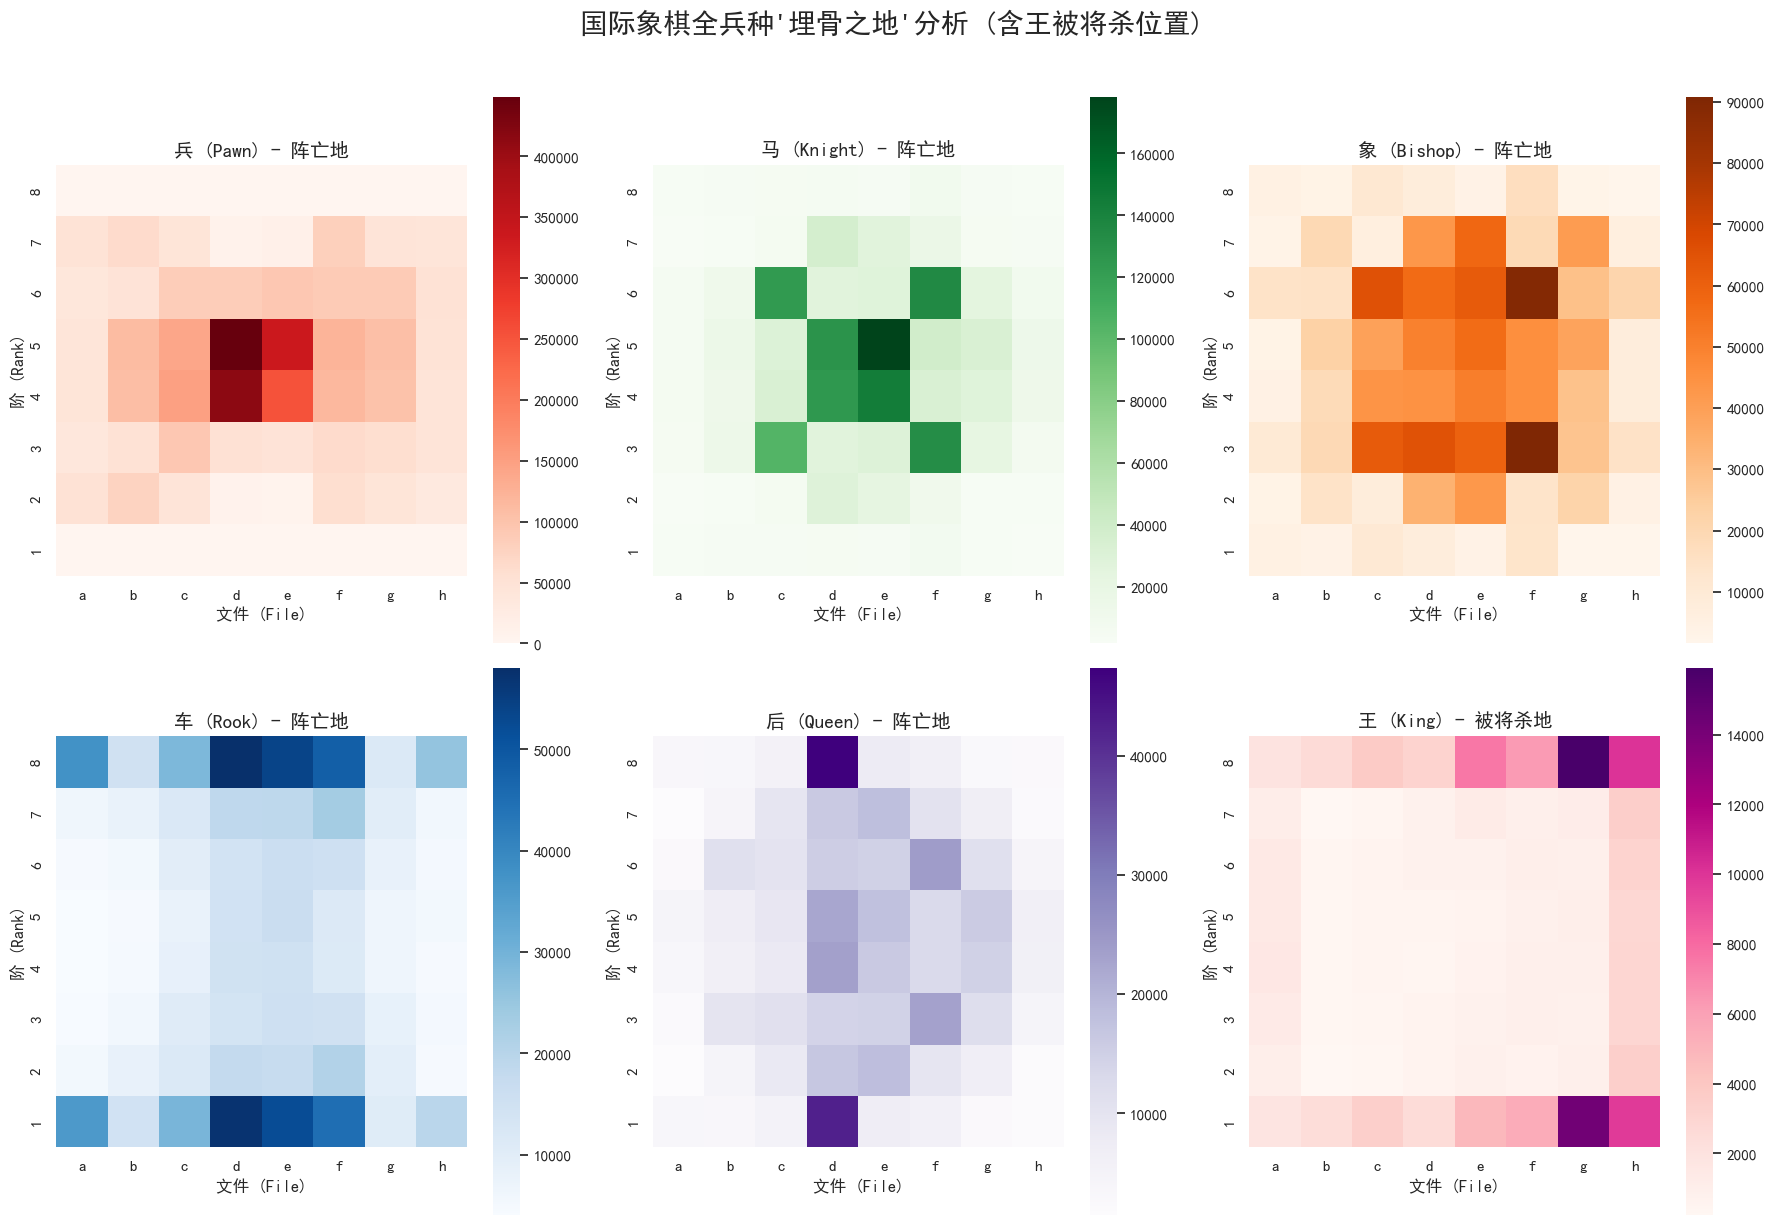

In [16]:
# 检查数据是否存在
if 'piece_death_heatmaps' not in globals():
    print("【错误】数据未生成，请先运行 Cell 2")
else:
    # 设置画布：2行3列
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten() # 展平以便遍历

    x_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    y_labels = ['8', '7', '6', '5', '4', '3', '2', '1']

    # 定义要画的6种棋子
    pieces_to_plot = [
        (chess.PAWN, "兵 (Pawn) - 阵亡地", "Reds"),
        (chess.KNIGHT, "马 (Knight) - 阵亡地", "Greens"),
        (chess.BISHOP, "象 (Bishop) - 阵亡地", "Oranges"),
        (chess.ROOK, "车 (Rook) - 阵亡地", "Blues"),
        (chess.QUEEN, "后 (Queen) - 阵亡地", "Purples"),
        (chess.KING, "王 (King) - 被将杀地", "RdPu") # 专用的红紫色，代表致命
    ]

    for i, (ptype, name, cmap) in enumerate(pieces_to_plot):
        heatmap_data = piece_death_heatmaps[ptype]
        
        # 只有当有数据时才画热力图，避免全0报错或全白
        if heatmap_data.sum() > 0:
            sns.heatmap(heatmap_data, ax=axes[i], cmap=cmap, 
                        xticklabels=x_labels, yticklabels=y_labels, 
                        annot=False, square=True, cbar=True)
        else:
            axes[i].text(0.5, 0.5, "暂无数据\n(未检测到该类型事件)", 
                         ha='center', va='center', fontsize=12)
        
        axes[i].set_title(name, fontsize=14, fontweight='bold')
        axes[i].set_xlabel("文件 (File)")
        axes[i].set_ylabel("阶 (Rank)")

    plt.suptitle(f"国际象棋全兵种'埋骨之地'分析 (含王被将杀位置)", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

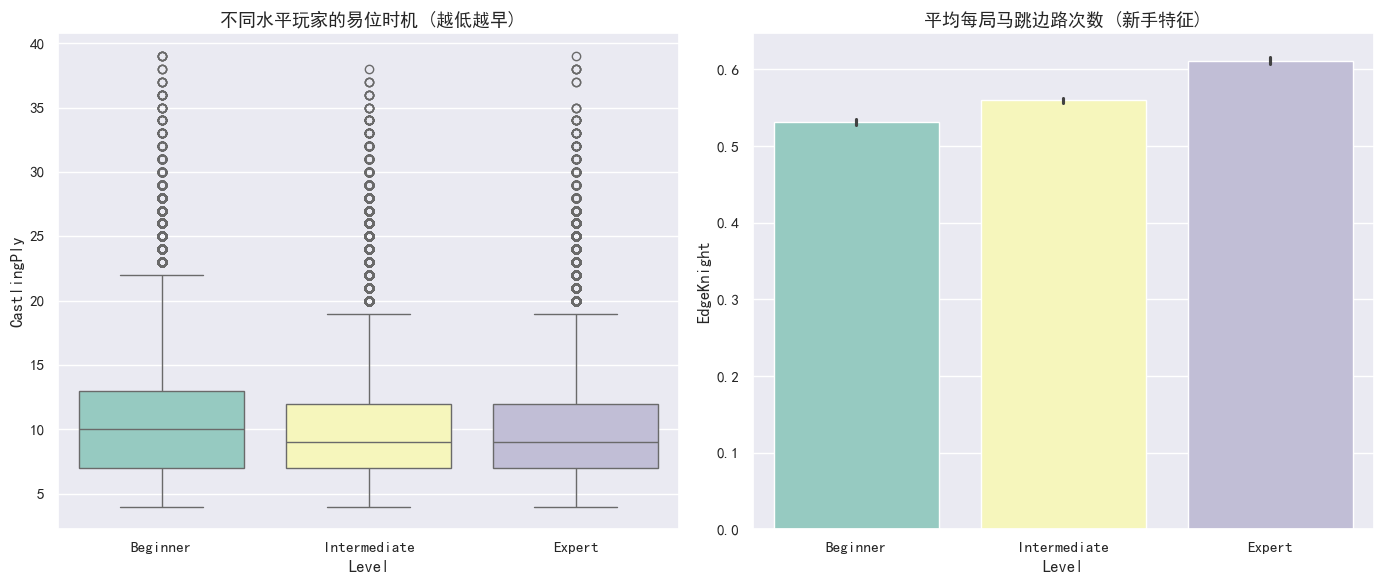

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
order = ["Beginner", "Intermediate", "Expert"]

# 图1：易位习惯
sns.boxplot(x='Level', y='CastlingPly', data=df[df['CastlingPly'] < 40], 
            order=order, palette="Set3", ax=axes[0])
axes[0].set_title("不同水平玩家的易位时机 (越低越早)", fontsize=13)

# 图2：马跳边路
sns.barplot(x='Level', y='EdgeKnight', data=df, 
            order=order, palette="Set3", ax=axes[1])
axes[1].set_title("平均每局马跳边路次数 (新手特征)", fontsize=13)

plt.tight_layout()
plt.show()
